# 데이콘 이상탐지 데이터 분석
---

In [1]:
!pip install --upgrade matplotlib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from ipywidgets import interact, widgets

![관망구조B](관망구조_B.jpg)

# M7펌프가 24/06/26 05:58 1에서 0으로 변함
# 압력계가 비정상이되면 14:20-부터 급격히 떨어지다가 정상화된 14:50부터 다시 올라감
- P가 anomaly 관측에 주요 변수로 보임(P8)
- 밸브 개도율 수시 변동과 p8 p9 사이 상관관계 가능
- Q4는 굉장히 중요한 변수다
- Q5가 완전 음에서 완전 양으로 바뀐다
- p7하고 q4가 상관관계 -1에 가까워 q4와 p7사이에 밸브는 개도율이 수시로 변동한다 
- p7이 압력이 높아졌을 때 밸브를 닫아서 q4의 유량이 감소했을 가능성이 있음
- 베르누이 원리에 의해서 정상상태에서는 유량과 압력이 음의 상관관계다
- 근데 anomaly상황에서 q5에서 양의 상관관계다
Anomaly 상황에서 유량과 압력이 양의 상관관계를 보이는 것은 시스템에 비정상적인 상태가 발생했음을 시사합니다. 이는 다음과 같은 상황을 나타낼 수 있습니다:
누수 발생: 파이프라인에 누수가 발생하면, 압력이 증가함에 따라 누수 지점을 통한 유량도 증가할 수 있습니다2. 이는 정상적인 흐름과는 다른 패턴을 보이게 됩니다.
막힘 현상: 파이프라인에 부분적인 막힘이 발생하면, 압력이 증가하면서 동시에 유량도 증가할 수 있습니다. 이는 막힘을 통과하기 위해 더 높은 압력이 필요하기 때문입니다2.
펌프 오작동: 시스템 내 펌프가 비정상적으로 작동하면, 압력과 유량이 동시에 증가하는 현상이 나타날 수 있습니다3.
밸브 오작동: 제어 밸브가 제대로 작동하지 않으면, 압력과 유량 사이의 정상적인 관계가 무너질 수 있습니다.
결론
이러한 관찰 결과는 시스템의 정상 상태와 비정상 상태를 구분하는 중요한 지표가 될 수 있습니다4. 유량과 압력 사이의 관계가 갑자기 변화하는 것은 시스템에 문제가 발생했음을 나타내는 신호일 수 있으며, 이를 통해 조기에 문제를 감지하고 대응할 수 있습니다. 따라서 이러한 패턴 변화를 모니터링하는 것은 수도 공급 시스템의 효율적인 관리와 유지보수에 매우 중요합니다5.

# 데이터 정보

In [3]:
df_A = pd.read_csv("TRAIN_B.csv")

print(df_A.columns)
print("칼럼 수 : ",len(df_A.columns))
print("차원 : ",df_A.shape)


# 새로운 열 생성:
df_A['leakage'] = df_A['Q1'] - df_A['Q2'] -df_A['Q3'] - df_A['Q4']

Index(['timestamp', 'Q1', 'Q2', 'Q3', 'Q4', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6',
       'P7', 'P8', 'P9', 'P10', 'anomaly', 'P1_flag', 'P2_flag', 'P3_flag',
       'P4_flag', 'P5_flag', 'P6_flag', 'P7_flag', 'P8_flag', 'P9_flag',
       'P10_flag'],
      dtype='object')
칼럼 수 :  26
차원 :  (41760, 26)


In [4]:
# 2. 양수 leakage만 필터링
positive_mask = df_A['leakage'] > 0
df_positive = df_A[positive_mask].copy()

In [5]:
# 2. Isolation Forest 모델 정의
iso_forest = IsolationForest(
    contamination=0.03,  # anomaly 비율
    random_state=42,
    n_estimators=100
)

In [6]:
# 3. 학습 데이터 준비 (leakage만 사용)
X = df_A['leakage'].values.reshape(-1, 1)
iso_forest.fit(X)

IsolationForest(contamination=0.03, random_state=42)

In [7]:
# 4. Anomaly 예측
anomaly_pred = iso_forest.predict(X)
df_A['predicted_anomaly'] = np.where(anomaly_pred == -1, 1, 0)

In [8]:
# 5. 시각화
plt.figure(figsize=(15, 8))

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

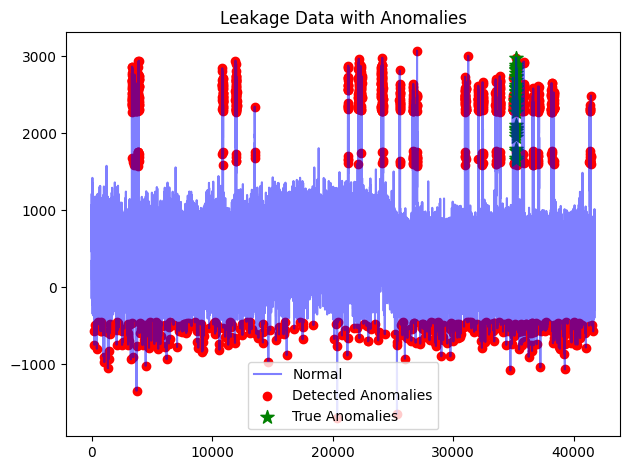

In [9]:
# Leakage 데이터와 예측된/실제 anomaly 플롯
plt.plot(df_A.index, df_A['leakage'], 'b-', label='Normal', alpha=0.5)
plt.scatter(df_A.index[df_A['predicted_anomaly'] == 1],
           df_A['leakage'][df_A['predicted_anomaly'] == 1],
           color='red', label='Detected Anomalies')
plt.scatter(df_A.index[df_A['anomaly'] == 1],
           df_A['leakage'][df_A['anomaly'] == 1],
           color='green', marker='*', s=100, label='True Anomalies')
plt.title('Leakage Data with Anomalies')
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# 6. 성능 평가
true_anomalies = df_A[df_A['anomaly'] == 1]
detected_anomalies = df_A[df_A['predicted_anomaly'] == 1]
matching = df_A[(df_A['anomaly'] == 1) & (df_A['predicted_anomaly'] == 1)]

print(f"실제 anomaly 수: {len(true_anomalies)}")
print(f"탐지된 anomaly 수: {len(detected_anomalies)}")
print(f"일치하는 anomaly 수: {len(matching)}")
print(f"탐지 정확도: {len(matching)/len(true_anomalies)*100:.2f}%")

실제 anomaly 수: 33
탐지된 anomaly 수: 1243
일치하는 anomaly 수: 25
탐지 정확도: 75.76%


In [11]:
# 7. 주요 anomaly 시점 출력
print("\n주요 anomaly 발생 시점:")
print(true_anomalies[['timestamp', 'leakage']].head())


주요 anomaly 발생 시점:
            timestamp    leakage
35209  24/07/25 10:49  1681.8257
35210  24/07/25 10:50  2603.0167
35211  24/07/25 10:51  1951.8399
35212  24/07/25 10:52  1649.9912
35213  24/07/25 10:53  2058.3237


In [12]:
# 4. 예측
X = df_positive['leakage'].values.reshape(-1, 1)
df_positive['predicted_anomaly'] = np.where(iso_forest.predict(X) == -1, 1, 0)

In [13]:
# 5. 시각화
plt.figure(figsize=(15, 8))

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

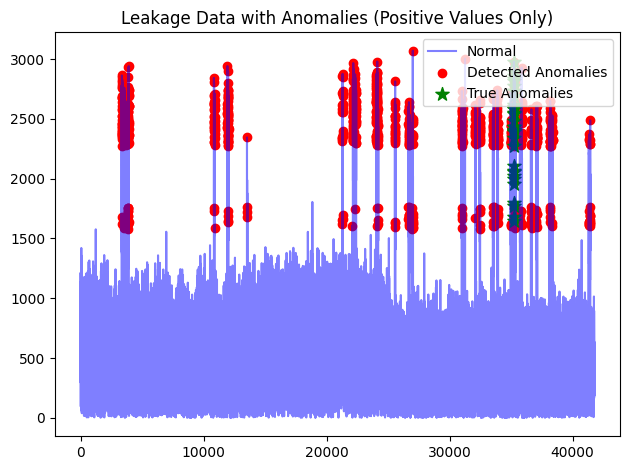

In [14]:
# 전체 데이터 플롯 (양수 값만)
plt.plot(df_positive.index, df_positive['leakage'], 
         'b-', label='Normal', alpha=0.5)

# 탐지된 anomaly 플롯
plt.scatter(df_positive.index[df_positive['predicted_anomaly'] == 1],
           df_positive['leakage'][df_positive['predicted_anomaly'] == 1],
           color='red', label='Detected Anomalies')
# 실제 anomaly 플롯
plt.scatter(df_positive.index[df_positive['anomaly'] == 1],
           df_positive['leakage'][df_positive['anomaly'] == 1],
           color='green', marker='*', s=100, label='True Anomalies')

plt.title('Leakage Data with Anomalies (Positive Values Only)')
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
# 6. 성능 평가
true_anomalies = df_positive[df_positive['anomaly'] == 1]
detected_anomalies = df_positive[df_positive['predicted_anomaly'] == 1]
matching = df_positive[(df_positive['anomaly'] == 1) & 
                      (df_positive['predicted_anomaly'] == 1)]

In [16]:
print(f"실제 anomaly 수: {len(true_anomalies)}")
print(f"탐지된 anomaly 수: {len(detected_anomalies)}")
print(f"일치하는 anomaly 수: {len(matching)}")
print(f"탐지 정확도: {len(matching)/len(true_anomalies)*100:.2f}%")

실제 anomaly 수: 33
탐지된 anomaly 수: 837
일치하는 anomaly 수: 25
탐지 정확도: 75.76%


In [17]:
def plot_leakage_anomalies(diff_threshold, std_threshold):
    # 1. Leakage 변화율과 표준편차 계산
    df_A['leakage_diff'] = df_A['leakage'].diff()
    df_A['leakage_std'] = df_A['leakage'].rolling(window=5).std()
    
    # 2. Threshold 기반 anomaly 탐지
    anomaly_mask = (abs(df_A['leakage_diff']) > diff_threshold) | \
                  (df_A['leakage_std'] > std_threshold)
    
    # 3. 시각화
    plt.figure(figsize=(15, 10))
    
    # Leakage 데이터와 anomaly 플롯
    plt.subplot(3, 1, 1)
    plt.plot(df_A.index, df_A['leakage'], 'b-', label='Normal', alpha=0.5)
    plt.scatter(df_A.index[anomaly_mask],
               df_A['leakage'][anomaly_mask],
               color='red', label='Anomalies')
    plt.title('Leakage Data with Anomalies')
    plt.legend()
    
    # 변화율 플롯
    plt.subplot(3, 1, 2)
    plt.plot(df_A.index, df_A['leakage_diff'], 'g-', label='Diff', alpha=0.5)
    plt.axhline(y=diff_threshold, color='r', linestyle='--', label='Upper Threshold')
    plt.axhline(y=-diff_threshold, color='r', linestyle='--', label='Lower Threshold')
    plt.title('Leakage Change Rate')
    plt.legend()
    
    # 이동 표준편차 플롯
    plt.subplot(3, 1, 3)
    plt.plot(df_A.index, df_A['leakage_std'], 'purple', label='Std', alpha=0.5)
    plt.axhline(y=std_threshold, color='r', linestyle='--', label='Threshold')
    plt.title('Rolling Standard Deviation')
    plt.legend()
    
    plt.tight_layout()
    
    # 통계 출력
    print(f"Number of anomalies detected: {anomaly_mask.sum()}")
    print(f"Percentage of anomalies: {(anomaly_mask.sum()/len(df_A))*100:.2f}%")

# 인터랙티브 위젯 생성
interact(
    plot_leakage_anomalies,
    diff_threshold=widgets.FloatSlider(
        value=1000,
        min=100,
        max=5000,
        step=100,
        description='Diff Threshold:'
    ),
    std_threshold=widgets.FloatSlider(
        value=500,
        min=100,
        max=2000,
        step=100,
        description='Std Threshold:'
    )
)

interactive(children=(FloatSlider(value=1000.0, description='Diff Threshold:', max=5000.0, min=100.0, step=100…

<function __main__.plot_leakage_anomalies(diff_threshold, std_threshold)>